# Resume of the two papers studied that used BAVED dataset

## First paper : 
##### Arabic Speech Emotion Recognition Employing Wav2vec2.0 and HuBERT Based on BAVED  Dataset

This paper firstly go through the challenges of working in Arabic speech emotion recognition (ASER) due to the **lack of the available dataset** sets particularly in
dialogues, the **complexity of the arabic language** and the important role of the **contex**t in which the **words or expression** are used.
Then It talks about the previous works in this field and the SOTA (state of the art) techniques used and discussed.

**Models Deployed** : 
**Wav2vec2.0** : 
* Encode the raw audio through a convolutional layer to extract features and transform it into a numerical representation
* Mask random portions of the encoded speech representation in various ways , like masking random time steps or frequency bands
* The model doesn't try to predict the masked portion as HuBERT does, instead, it focuses on contrastive task between the original masked portion to other version of it that has been altered, the model learns to differentiate similar representations from dissimilar ones.

The main advantage of this algorithm is leveraging unlabeled data.

**HuBERT** :
* Encode the audio just as Wav2vec2.0 does to extract features and transform into continuous latent representations.
* The masking step here is different as it masks randomly certain sections. This creates the challenge that this model will try to solve of predicting the masked parts.
* THe model attempt to predict the masked portions. This forces the model to learn the underlying structure and relationships within the speech data.           
* To guide the masked predictions, HuBERT utilizes pre-defined cluster targets. Predicting the correct cluster for the masked segment helps the model understand the masked speech content.

The advantage of this model is its efficiency as it requires labeled data for training 

## Second paper : 
##### Transformer-Based Multilingual Speech Emotion Recognition Using Data Augmentation and Feature Fusion

This paper used transformer model for emotion recognition but before training it, the methodology used was : 
* **Data Augmentation** : Data augmentation was used to prevent overfitting,robust performance and generalize accuracy. For that adding **Gaussian noise** was the first step then **pitch shifting** and **time stretching** 
            
* **Feature Extraction** : The total number of features extracted for this study is **273** from **7** different methods :
    * Mel-spectrogram
    * Chromagram
    * MFCC
    * Delta-MFCC
    * Delta-delta MFCC
    * Tonnetz
* **Evaluation Metrics** : **Accuracy**, **Recall** and **Precision** are metrics that has been used.
* **Transformer Model** :  The specific transformer model used here is a three-layer transformer. The layers in a transformer model are typically encoder layers and decoder layers. Encoder layers process the input sequence, while decoder layers generate the output sequence. The **Architecture** of the model is the following
    
    * The model has three layers.   
    * The first layer is an input layer that takes an input of shape (None, None, 273). This means that the input can have any batch size and sequence length, and each element in the sequence has a dimension of 273.
    * The second layer is an encoder layer that processes the input sequence. The output of the encoder layer has the same shape as the input, (None, None, 273).
    * The third layer is a decoder layer that generates the output sequence. The output of the decoder layer has a shape of (None, 7). This means that the output can have any batch size and sequence length, and each element in the sequence has a dimension of 7.


# Code

## Import main libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import wavfile
from IPython.display import Audio, display

## Engine

In [4]:
import os
import tqdm


class Engine(object):
    def __init__(self, folder_path):
        self.folder_path = folder_path
        self.wavs_files = []
        self.extract_vocals()
        self.wavs_df = pd.DataFrame(self.wavs_files, columns=['filename'])
        self.wavs_df.set_index('filename', inplace=True)

    def __iterate_wavs(self):

        for root, _, files in os.walk(self.folder_path):
            for filename in files:
                if filename.endswith(".wav"):  # Check for WAV extension
                    yield os.path.join(filename)  # Yield full path

    def extract_vocals(self):
        for wav_file in (self.__iterate_wavs()):
            # print(f"Found WAV file: {wav_file}")
            self.wavs_files.append(wav_file)

    def classify_files(self):
        new_columns = {
            'speaker_id': np.empty(len(self.wavs_files), dtype=np.float_),
            'speaker_gender': np.empty(len(self.wavs_files), dtype=np.str_),
            'speaker_age': np.empty(len(self.wavs_files), dtype=np.float_),
            'spoken_word': np.empty(len(self.wavs_files), dtype=np.float_),
            'spoken_emotion': np.empty(len(self.wavs_files), dtype=np.float_),
            'record_id': np.empty(len(self.wavs_files), dtype=np.str_)
        }

        # Concatenate along columns (axis=1)
        self.wavs_df = pd.concat([self.wavs_df, pd.DataFrame(new_columns)])
        self.wavs_df = self.wavs_df.iloc[:len(self.wavs_files)]

        for wav_file in self.wavs_files:
            wav_info = wav_file.split('-')
            # print(wav_info)
            self.wavs_df.loc[wav_file, :] = wav_info

        for idx, value in enumerate(self.wavs_df.loc[:, 'record_id']):
            self.wavs_df.iloc[idx, -1] = value.split('.')[0]






#### Instantiate engine

In [5]:
folder_path = "../Basic-Arabic-Vocal-Emotions-Dataset//"
engine = Engine(folder_path)


In [6]:
engine.wavs_df.head()


""
filename
0-m-21-0-1-105.wav
0-m-21-0-2-106.wav
1-m-20-0-1-107.wav
10-f-20-0-1-0.wav
100-f-6-0-0-0.wav


In [7]:
engine.classify_files()

In [8]:
from scipy.fftpack import idct
import warnings

warnings.filterwarnings("ignore")


## Fonctions utiles
def Mel2Hz(mel): return 700 * (np.power(10, mel / 2595) - 1)


def Hz2Mel(freq): return 2595 * np.log10(1 + freq / 700)


def Hz2Ind(freq, fs, Tfft): return (freq * Tfft / fs).astype(int)


def hamming(T): return 0.54 - 0.46 * np.cos(2 * np.pi * np.arange(T) / (T - 1))


#Réalisation d'un banc de filtres mel
def FiltresMel(fs, nf=36, Tfft=512, fmin=100, fmax=8000):
    Indices = Hz2Ind(Mel2Hz(np.linspace(Hz2Mel(fmin), Hz2Mel(min(fmax, fs / 2)), nf + 2)), fs, Tfft)
    filtres = np.zeros((int(Tfft / 2), nf))
    for i in range(nf): filtres[Indices[i]:Indices[i + 2], i] = hamming(Indices[i + 2] - Indices[i])
    return filtres


#Calcul du spectrogramme
def spectrogram(x, T, p, Tfft):
    S = []
    for i in range(0, len(x) - T, p): S.append(x[i:i + T] * hamming(T))  #fenêtrage 
    S = np.fft.fft(S, Tfft)  #Transformée de Fourier
    return np.abs(S), np.angle(S)  #spectre d'amplitude et de phase


#Calcul des mfcc
def mfcc(data, filtres, nc=13, T=256, p=64, Tfft=512):
    data = (data[1] - np.mean(data[1])) / np.std(data[1])  #normaliser les données
    amp, ph = spectrogram(data, T, p, Tfft)
    amp_f = np.log10(np.dot(amp[:, :int(Tfft / 2)], filtres) + 1)
    return idct(amp_f, n=nc, norm='ortho')


In [9]:
fs = 8000  #la fréquence d'échantillonage des exemples
filtres = FiltresMel(fs)  #réalisation des filtres auditifs

# Extract audio files and apply mfcc

In [10]:
words = ['like', 'didnt like', 'this', 'movie', 'super', 'correct', 'bad']  #les mots prononcés
nc = 100  # number of coefficients to extract with MFCC
filtered_audio = []
for index, row in engine.wavs_df.iterrows():
    filename = os.path.join(folder_path, row[3], index)  

    # Check if file exists before processing
    if os.path.exists(filename):
        try:
            filtered_audio.append(mfcc(wavfile.read(filename), filtres, nc=nc))
        except FileNotFoundError:
            print(f"Warning: File not found: {filename}. Skipping...")  
    else:
        print(f"Warning: File not found: {filename}. Skipping...")  



**Note** : Changin number of coefficient from 13 to 100 improved the model by 15%-30%

### Encode gender 

In [11]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
engine.wavs_df['speaker_gender'] = encoder.fit_transform(engine.wavs_df['speaker_gender'])
engine.wavs_df.head()

,speaker_id,speaker_gender,speaker_age,spoken_word,spoken_emotion,record_id
0-m-21-0-1-105.wav,0,1,21,0,1,105
0-m-21-0-2-106.wav,0,1,21,0,2,106
1-m-20-0-1-107.wav,1,1,20,0,1,107
10-f-20-0-1-0.wav,10,0,20,0,1,0
100-f-6-0-0-0.wav,100,0,6,0,0,0


## One hot encoding targets

In [12]:
coded_df = pd.get_dummies(data=engine.wavs_df, columns=['speaker_gender', 'spoken_emotion','spoken_word'])
coded_df

,speaker_id,speaker_age,record_id,speaker_gender_0,speaker_gender_1,spoken_emotion_0,spoken_emotion_1,spoken_emotion_2,spoken_word_0,spoken_word_1,spoken_word_2,spoken_word_3,spoken_word_4,spoken_word_5,spoken_word_6
0-m-21-0-1-105.wav,0,21,105,0,1,0,1,0,1,0,0,0,0,0,0
0-m-21-0-2-106.wav,0,21,106,0,1,0,0,1,1,0,0,0,0,0,0
1-m-20-0-1-107.wav,1,20,107,0,1,0,1,0,1,0,0,0,0,0,0
10-f-20-0-1-0.wav,10,20,0,1,0,0,1,0,1,0,0,0,0,0,0
100-f-6-0-0-0.wav,100,6,0,1,0,1,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56-f-40-6-2-1695.wav,56,40,1695,1,0,0,0,1,0,0,0,0,0,0,1
6-m-21-6-0-1848.wav,6,21,1848,0,1,1,0,0,0,0,0,0,0,0,1
7-m-22-6-0-1849.wav,7,22,1849,0,1,1,0,0,0,0,0,0,0,0,1
8-m-18-6-2-1850.wav,8,18,1850,0,1,0,0,1,0,0,0,0,0,0,1


In [13]:
target_emotions = coded_df[['spoken_emotion_0','spoken_emotion_1','spoken_emotion_2']]
target_genders = coded_df[['speaker_gender_0','speaker_gender_1']]
target_words = coded_df[['spoken_word_0','spoken_word_1','spoken_word_2','spoken_word_3','spoken_word_4','spoken_word_5','spoken_word_6']]

# Get max shape 
Get the maximum length of the mfcc samples to reshape others the same shape

In [14]:

def get_max_shape(array):
    max_shape = 0
    for value in array:
        if value.shape[0] > max_shape:
            max_shape = value.shape[0]
    return max_shape


max_shape = get_max_shape(filtered_audio)

# Zero padding (post_padding)

In [15]:
def post_padding(array, max_shape):
    new_array = array.copy()
    for idx, value in enumerate(array):
        shape0 = (value.shape)[0]
        pad0 = np.zeros((max_shape - shape0, nc))
        new_array[idx] = np.concatenate((value, pad0))

    return new_array


post_padding_audios = post_padding(filtered_audio, max_shape)
post_padding_audios = np.array(post_padding_audios)
post_padding_audios.shape  # 1935 files with 1276,nc shape

(1935, 1276, 100)

# Zero padding (pre_padding)

In [16]:
def pre_padding(array, max_shape):
    new_array = array.copy()
    for idx, value in enumerate(array):
        shape0 = (value.shape)[0]
        pad0 = np.zeros((max_shape - shape0, nc))
        new_array[idx] = np.concatenate((pad0, value))

    return new_array


pre_padding_audios = pre_padding(filtered_audio, max_shape)
pre_padding_audios = np.array(pre_padding_audios)
pre_padding_audios.shape  # 1935 files with 1276,nc shape

(1935, 1276, 100)

# Random padding

In [17]:
import random 
def random_padding(array, max_shape):
    new_array = array.copy()
    for idx, value in enumerate(array):
        shape0 = (value.shape)[0]
        random_nb = random.randint(0,max_shape-shape0)
        pre_pad0 = np.zeros((random_nb, nc))
        post_pad0 = np.zeros((max_shape - (random_nb+shape0), nc))
        new_array[idx] = np.concatenate((pre_pad0, value, post_pad0))

    return new_array


random_padding_audios = random_padding(filtered_audio, max_shape)
random_padding_audios = np.array(random_padding_audios)
random_padding_audios.shape  # 1935 files with 1276,nc shape

(1935, 1276, 100)

Random padding gave the **worst result**, It shouldn't be **static output** instead, at **each epoch** performing this random padding to the samples

# Notice 
I noticed that there is **no difference** whether using **pre padding** or **post padding**

In [18]:
X = pre_padding_audios
y_emotions = target_emotions[:len(X)]  # Because of ignored files
y_genders = target_genders[:len(X)]  # Because of ignored files
y_words = target_words[:len(X)]  # Because of ignored files
X.shape, y_emotions.shape


((1935, 1276, 100), (1935, 3))

# Data split

In [19]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)



# Summary :
### Model Conv2D : 
#### Architecture :
Conv1D(16, (7,7)) -> MaxPool(2,2) -> Conv1D(32, (5,5)) -> MaxPool(2,2) -> Dropout(0.3) -> Conv1D(64, (3,3)) -> MaxPool(2,2) -> Dropout(0.3)  -> Flatten() -> FC(512) -> Dropout(0.6) -> FC(len(target))
#### Hyperparameters :
Optimizer : adam, lr : 0.001 (decay= 0.95), lossFunction : CategoricalCrossentropy(), batch_size=32, epochs=20

In [20]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y_emotions[:len(X)], test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_holdout, y_holdout, test_size=0.5, random_state=42)

# with tf.device('/cpu:0'):
#     X_train = tf.expand_dims(X_train, axis=-1)
#     X_test = tf.expand_dims(X_test, axis=-1)

In [21]:
X_train.shape

(1354, 1276, 100)

In [22]:
CNN_model1D = tf.keras.Sequential([
    tf.keras.layers.Conv1D(32, (3), activation='relu', input_shape=( X_train.shape[1],X_train.shape[2]),
                           kernel_regularizer=tf.keras.regularizers.L2(1e-6)),  # Input layer with channel dimension
    tf.keras.layers.MaxPooling1D((2)),
    tf.keras.layers.Conv1D(64, (3), activation='relu',kernel_regularizer=tf.keras.regularizers.L2(1e-6)),  # Input layer with channel dimension
    tf.keras.layers.MaxPooling1D((2)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv1D(128, (3), activation='relu',kernel_regularizer=tf.keras.regularizers.L2(1e-6)),  # Input layer with channel dimension
    tf.keras.layers.MaxPooling1D((2)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Flatten(),  # Flatten before dense layers
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(units=y_emotions.shape[1], activation='softmax')
])

In [23]:
CNN_model1D.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Adjust learning rate as needed
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy'])

In [24]:

def lr_schedule(epoch, lr):
  if lr < 1.e-06 : # To avoid reaching tiny learning rates
      return lr
  decay_rate = 0.99  # Learning rate decay rate
  return lr * decay_rate**epoch

learning_rate_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule)


# Emotions Recognition

In [25]:
with tf.device('/GPU:0'):
    CNN_model1D.fit(X_train, y_train, batch_size=32, epochs=20,callbacks=[learning_rate_scheduler], validation_data=(X_val, y_val))

Epoch 1/20
43/43 [==============================] - 5s 23ms/step - loss: 1.0769 - accuracy: 0.4439 - val_loss: 0.9495 - val_accuracy: 0.4931 - lr: 0.0010
Epoch 2/20
43/43 [==============================] - 1s 13ms/step - loss: 0.8608 - accuracy: 0.5827 - val_loss: 0.8314 - val_accuracy: 0.6276 - lr: 9.9000e-04
Epoch 3/20
43/43 [==============================] - 1s 13ms/step - loss: 0.7693 - accuracy: 0.6470 - val_loss: 0.8265 - val_accuracy: 0.5552 - lr: 9.7030e-04
Epoch 4/20
43/43 [==============================] - 1s 13ms/step - loss: 0.7092 - accuracy: 0.6684 - val_loss: 0.7434 - val_accuracy: 0.6793 - lr: 9.4148e-04
Epoch 5/20
43/43 [==============================] - 1s 12ms/step - loss: 0.6564 - accuracy: 0.7134 - val_loss: 0.7067 - val_accuracy: 0.6690 - lr: 9.0438e-04
Epoch 6/20
43/43 [==============================] - 1s 12ms/step - loss: 0.5770 - accuracy: 0.7496 - val_loss: 0.6774 - val_accuracy: 0.6897 - lr: 8.6006e-04
Epoch 7/20
43/43 [==============================] - 1s 1

In [26]:
emotions_accuracy = CNN_model1D.evaluate(X_test, y_test)
print(f'Emotions recognition accuracy : {emotions_accuracy[1]}')

10/10 [==============================] - 0s 7ms/step - loss: 0.8990 - accuracy: 0.6873
Emotions recognition accuracy : 0.6872852444648743


In [27]:
y_pred = CNN_model1D.predict(X_test)

10/10 [==============================] - 0s 5ms/step


In [28]:
y_pred1=np.argmax(y_pred,axis=1)
y_test1=np.argmax(np.array(y_test),axis=1)

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


<Axes: >

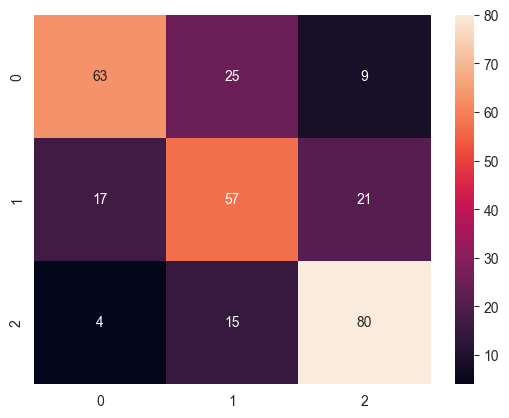

In [30]:
cf_matrix = confusion_matrix(y_pred1,y_test1)
sns.heatmap(cf_matrix, annot=True)

# Gender Recognition

In [31]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y_genders, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_holdout, y_holdout, test_size=0.5, random_state=42)

# with tf.device('/cpu:0'):
#     X_train = tf.expand_dims(X_train, axis=-1)
#     X_test = tf.expand_dims(X_test, axis=-1)

In [32]:
X_train.shape

(1354, 1276, 100)

In [33]:

all_layers = CNN_model1D.layers

# Extract all layers except the output
base_model = tf.keras.Sequential(all_layers[:-1])

In [34]:
gender_model = tf.keras.Sequential(base_model.layers)
gender_model.add(tf.keras.layers.Dense(units=y_genders.shape[-1], activation='softmax'))

In [35]:
gender_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Adjust learning rate as needed
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy'])

In [36]:
gender_model.fit(X_train, y_train, batch_size=32, epochs=20,callbacks=[learning_rate_scheduler], validation_data=(X_val, y_val))

Epoch 1/20
43/43 [==============================] - 1s 19ms/step - loss: 0.4713 - accuracy: 0.7866 - val_loss: 0.1888 - val_accuracy: 0.9552 - lr: 0.0010
Epoch 2/20
43/43 [==============================] - 1s 12ms/step - loss: 0.1291 - accuracy: 0.9505 - val_loss: 0.0685 - val_accuracy: 0.9724 - lr: 9.9000e-04
Epoch 3/20
43/43 [==============================] - 1s 14ms/step - loss: 0.0498 - accuracy: 0.9852 - val_loss: 0.0611 - val_accuracy: 0.9759 - lr: 9.7030e-04
Epoch 4/20
43/43 [==============================] - 1s 13ms/step - loss: 0.0401 - accuracy: 0.9838 - val_loss: 0.0607 - val_accuracy: 0.9759 - lr: 9.4148e-04
Epoch 5/20
43/43 [==============================] - 1s 12ms/step - loss: 0.0426 - accuracy: 0.9793 - val_loss: 0.0205 - val_accuracy: 0.9966 - lr: 9.0438e-04
Epoch 6/20
43/43 [==============================] - 1s 12ms/step - loss: 0.0162 - accuracy: 0.9941 - val_loss: 0.0218 - val_accuracy: 0.9931 - lr: 8.6006e-04
Epoch 7/20
43/43 [==============================] - 1s 1

In [37]:
gender_accuracy = gender_model.evaluate(X_test, y_test)
print(f'Geneder recognition accuracy : {gender_accuracy[1]}')

10/10 [==============================] - 0s 5ms/step - loss: 0.0716 - accuracy: 0.9828
Geneder recognition accuracy : 0.9828178882598877


In [38]:
y_pred = gender_model.predict(X_test)

10/10 [==============================] - 0s 5ms/step


In [39]:
y_pred1=np.argmax(y_pred,axis=1)
y_test1=np.argmax(np.array(y_test),axis=1)

<Axes: >

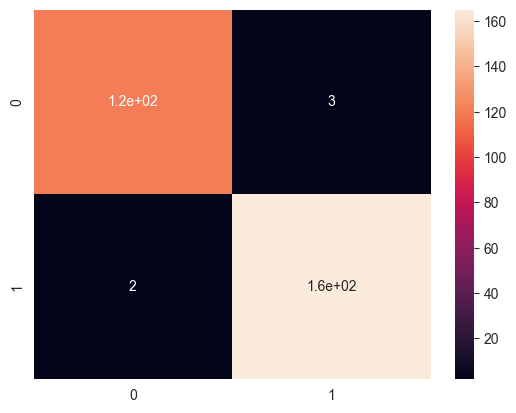

In [40]:
cf_matrix = confusion_matrix(y_pred1,y_test1)
sns.heatmap(cf_matrix, annot=True)

# Words Recognition

In [41]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y_words, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_holdout, y_holdout, test_size=0.5, random_state=42)


In [42]:
words_model = tf.keras.Sequential(base_model.layers)
words_model.add(tf.keras.layers.Dense(units=y_words.shape[-1], activation='softmax'))

In [43]:
words_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Adjust learning rate as needed
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy'])

In [44]:
# with tf.device('/GPU:0'):
words_model.fit(X_train, y_train, batch_size=32, epochs=20,callbacks=[learning_rate_scheduler], validation_data=(X_val, y_val))

Epoch 1/20
43/43 [==============================] - 2s 24ms/step - loss: 1.9026 - accuracy: 0.2792 - val_loss: 1.3776 - val_accuracy: 0.4621 - lr: 0.0010
Epoch 2/20
43/43 [==============================] - 1s 12ms/step - loss: 1.1433 - accuracy: 0.5606 - val_loss: 0.8847 - val_accuracy: 0.7000 - lr: 9.9000e-04
Epoch 3/20
43/43 [==============================] - 1s 29ms/step - loss: 0.7873 - accuracy: 0.7171 - val_loss: 0.6549 - val_accuracy: 0.8172 - lr: 9.7030e-04
Epoch 4/20
43/43 [==============================] - 1s 12ms/step - loss: 0.5540 - accuracy: 0.7947 - val_loss: 0.5311 - val_accuracy: 0.8379 - lr: 9.4148e-04
Epoch 5/20
43/43 [==============================] - 1s 12ms/step - loss: 0.4361 - accuracy: 0.8516 - val_loss: 0.4554 - val_accuracy: 0.8517 - lr: 9.0438e-04
Epoch 6/20
43/43 [==============================] - 1s 12ms/step - loss: 0.3050 - accuracy: 0.8951 - val_loss: 0.4943 - val_accuracy: 0.8655 - lr: 8.6006e-04
Epoch 7/20
43/43 [==============================] - 1s 1

In [45]:
words_accuracy = words_model.evaluate(X_test, y_test)
print(f'Words recognition accuracy : {words_accuracy[1]}')

10/10 [==============================] - 0s 6ms/step - loss: 0.5876 - accuracy: 0.8900
Words recognition accuracy : 0.8900343775749207


In [46]:
y_pred = words_model.predict(X_test)

10/10 [==============================] - 0s 5ms/step


In [47]:
y_pred1=np.argmax(y_pred,axis=1)
y_test1=np.argmax(np.array(y_test),axis=1)

<Axes: >

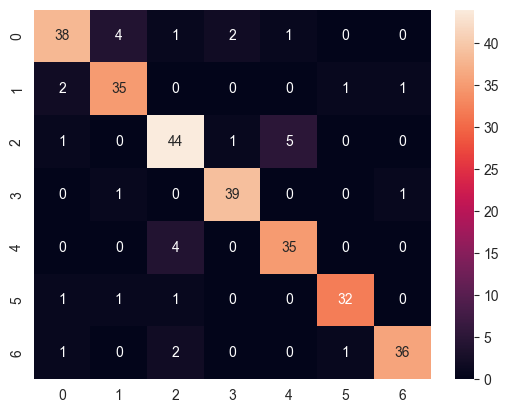

In [48]:
cf_matrix = confusion_matrix(y_pred1,y_test1)
sns.heatmap(cf_matrix, annot=True)

In [49]:
# CNN_model1D.save('1DCnnModel--78.69%')

This is the model that gave me the best results : 78.69% 

    tf.keras.layers.Conv1D(32, (3), activation='relu', input_shape=( X_train.shape[1],X_train.shape[2]),
                           kernel_regularizer=tf.keras.regularizers.L2(1e-6)),  # Input layer with channel dimension
    tf.keras.layers.MaxPooling1D((2)),
    tf.keras.layers.Conv1D(64, (3), activation='relu',kernel_regularizer=tf.keras.regularizers.L2(1e-6)),  # Input layer with channel dimension
    tf.keras.layers.MaxPooling1D((2)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv1D(128, (3), activation='relu',kernel_regularizer=tf.keras.regularizers.L2(1e-6)),  # Input layer with channel dimension
    tf.keras.layers.MaxPooling1D((2)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Flatten(),  # Flatten before dense layers
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(units=y_emotions.shape[1], activation='softmax')

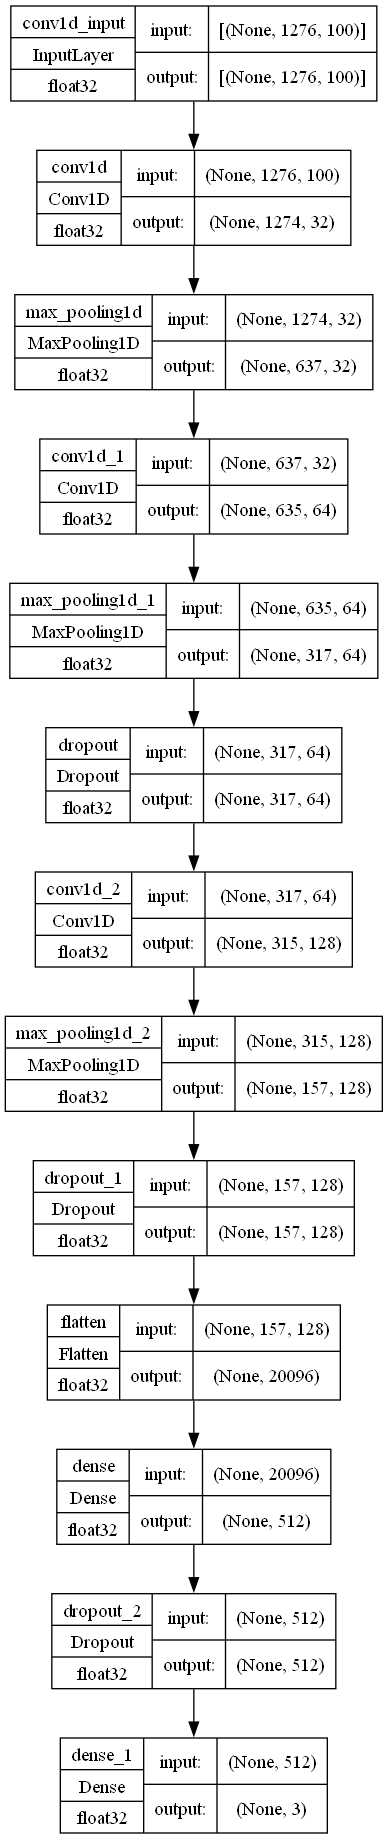

In [50]:
from tensorflow.keras.utils import plot_model

plot_model(CNN_model1D, show_shapes=True, show_layer_names=True, show_dtype=True)